# Hurricane Track Prediction - Visualization Suite

Comprehensive visualizations for the Kalman Filter hurricane track prediction project.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Configuration
FIG_SIZE = (10, 6)
DPI = 300
SAVE_DIR = 'figures/'

import os
os.makedirs(SAVE_DIR, exist_ok=True)


In [4]:
# Load processed dataset
df = pd.read_pickle("data/hurricane_paths_processed.pkl")
df = df.sort_values(['sid', 'iso_time']).reset_index(drop=True)

print(f"Loaded {len(df):,} observations from {df['sid'].nunique():,} storms")


Loaded 721,960 observations from 13,450 storms


## Results

In [19]:
def plot_forecast_error_vs_leadtime(rmse_results_baseline=None, rmse_results_adaptive=None, 
                                     save_path=None):
    """
    Plot RMSE vs lead time for baseline and adaptive KF models
    
    Args:
        rmse_results_baseline: Dict or DataFrame with lead times and RMSE values
                              Format: {'lead_times': [6, 12, 24, 48, 72], 'rmse': [15.86, 34.50, ...]}
        rmse_results_adaptive: Same format for adaptive model
        save_path: Path to save figure
    """
    
    # Default example data (replace with actual results)
    if rmse_results_baseline is None:
        print("Using example data. Replace with actual results from KF evaluation.")
        rmse_results_baseline = {
            'lead_times': [6, 12, 24, 48, 72],
            'rmse': [15.86, 34.50, 83.79, 216.74, 379.35]
        }
    
    if rmse_results_adaptive is None:
        rmse_results_adaptive = rmse_results_baseline.copy()  # Same for now
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Extract data
    if isinstance(rmse_results_baseline, dict):
        lead_times = rmse_results_baseline['lead_times']
        rmse_baseline = rmse_results_baseline['rmse']
    else:
        # Assume DataFrame
        lead_times = rmse_results_baseline.index if hasattr(rmse_results_baseline, 'index') else range(len(rmse_results_baseline))
        rmse_baseline = rmse_results_baseline.values if hasattr(rmse_results_baseline, 'values') else rmse_results_baseline
    
    if isinstance(rmse_results_adaptive, dict):
        rmse_adaptive = rmse_results_adaptive['rmse']
    else:
        rmse_adaptive = rmse_results_adaptive.values if hasattr(rmse_results_adaptive, 'values') else rmse_results_adaptive
    
    # Plot
    ax.plot(lead_times, rmse_baseline, 'o-', linewidth=2, markersize=8, 
           label='Base KF', color='blue')
    ax.plot(lead_times, rmse_adaptive, 's-', linewidth=2, markersize=8, 
           label='Adaptive-Q KF', color='red', linestyle='--')
    
    ax.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax.set_ylabel('RMSE (km)', fontsize=12)
    ax.set_title('Forecast Error vs Lead Time', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Add value labels
    for i, (lt, rmse) in enumerate(zip(lead_times, rmse_baseline)):
        ax.annotate(f'{rmse:.1f}', (lt, rmse), textcoords="offset points", 
                   xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

# Example usage (replace with actual results):
# plot_forecast_error_vs_leadtime(rmse_baseline, rmse_adaptive, save_path=f'{SAVE_DIR}fig8_forecast_error.png')




**Loading Kalman Filter Results from Data Folder**


In [20]:
# Load Kalman filter results from data folder
try:
    sliding_results_final = pd.read_pickle("data/kalman_results_sliding_results_final.pkl")
    sliding_results_improved = pd.read_pickle("data/kalman_results_sliding_results_improved.pkl")
    sliding_results = pd.read_pickle("data/kalman_results_sliding_results.pkl")
    test_results = pd.read_pickle("data/kalman_results_test_results.pkl")
    innovation_df = pd.read_pickle("data/kalman_results_innovation_df.pkl")
    
    print(f"  - sliding_results_final: {len(sliding_results_final):,} forecast instances")
    print(f"  - sliding_results_improved: {len(sliding_results_improved):,} forecast instances")
    print(f"  - sliding_results: {len(sliding_results):,} forecast instances")
    print(f"  - test_results: {len(test_results):,} storms")
    print(f"  - innovation_df: {len(innovation_df):,} time steps")
except Exception as e:
    print(f"Error loading results: {e}")
    print("Make sure Kalman filter evaluation has been run and results are saved in data/ folder")
    sliding_results_final = None
    sliding_results_improved = None
    sliding_results = None
    test_results = None
    innovation_df = None


  - sliding_results_final: 555 forecast instances
  - sliding_results_improved: 555 forecast instances
  - sliding_results: 555 forecast instances
  - test_results: 2,680 storms
  - innovation_df: 26,049 time steps


### Figure 8 — Forecast Error vs Lead Time (Using Actual Results)


Saved: figures/fig8a_forecast_error_rmse.png


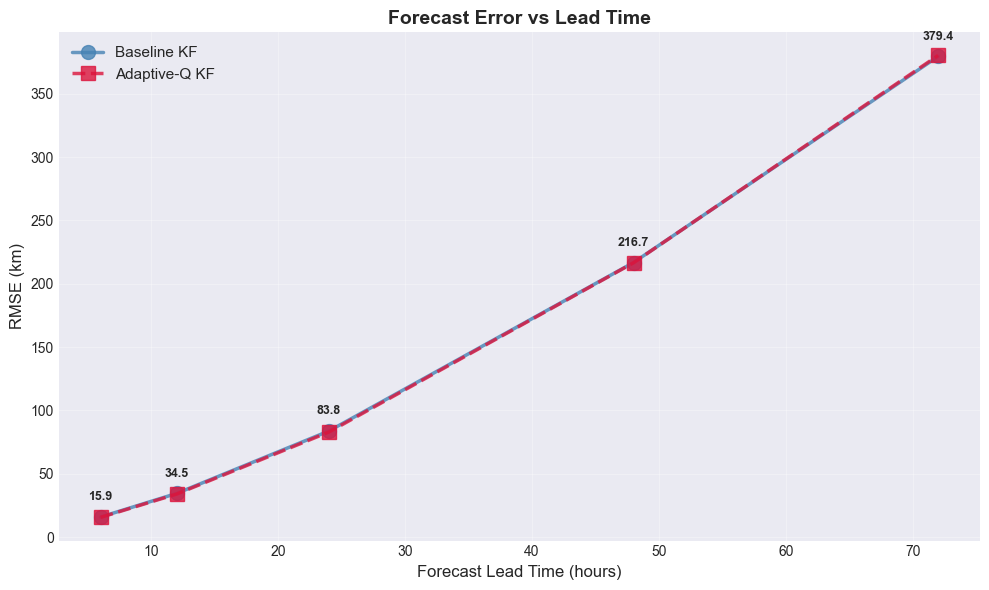

Saved: figures/fig8b_error_distribution_by_leadtime.png


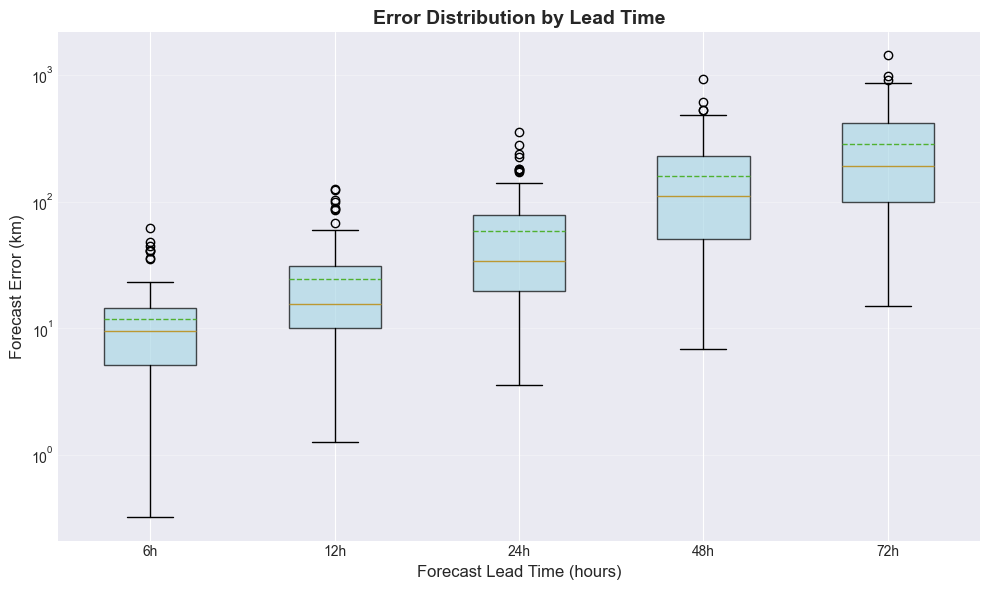

In [ ]:
def plot_forecast_error_vs_leadtime_actual(sliding_results_baseline=None, 
                                           sliding_results_improved=None, 
                                           save_dir=None):
    """
    Plot RMSE vs lead time using actual sliding window forecast results
    Saves each graph separately
    
    Args:
        sliding_results_baseline: DataFrame with columns ['lead_time_hours', 'error_km']
        sliding_results_improved: DataFrame with columns ['lead_time_hours', 'error_km']
        save_dir: Directory to save figures
    """
    
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Calculate RMSE by lead time for baseline
    if 'lead_time_hours' not in sliding_results_baseline.columns:
        print("Error: sliding_results_baseline missing 'lead_time_hours' column")
        return
    
    baseline_rmse = sliding_results_baseline.groupby('lead_time_hours')['error_km'].apply(
        lambda x: np.sqrt(np.mean(x**2))
    ).sort_index()
    lead_times = baseline_rmse.index.values
    
    # Plot 1: RMSE comparison (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(lead_times, baseline_rmse.values, 'o-', linewidth=2.5, markersize=10, 
            label='Baseline KF', color='steelblue', alpha=0.8)
    
    # Plot improved model if available
    if sliding_results_improved is not None and len(sliding_results_improved) > 0:
        if 'lead_time_hours' in sliding_results_improved.columns:
            improved_rmse = sliding_results_improved.groupby('lead_time_hours')['error_km'].apply(
                lambda x: np.sqrt(np.mean(x**2))
            ).sort_index()
            improved_lead_times = improved_rmse.index.values
            ax1.plot(improved_lead_times, improved_rmse.values, 's-', linewidth=2.5, 
                    markersize=10, label='Adaptive-Q KF', color='crimson', 
                    linestyle='--', alpha=0.8)
    
    ax1.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax1.set_ylabel('RMSE (km)', fontsize=12)
    ax1.set_title('Forecast Error vs Lead Time', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left', fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for lt, rmse in zip(lead_times, baseline_rmse.values):
        ax1.annotate(f'{rmse:.1f}', (lt, rmse), textcoords="offset points", 
                   xytext=(0,12), ha='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    save_path1 = f'{save_dir}fig8a_forecast_error_rmse.png'
    plt.savefig(save_path1, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path1}")
    plt.show()
    
    # Plot 2: Error distribution by lead time (box plot style) - separate figure
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    error_data = []
    labels = []
    for lt in sorted(sliding_results_baseline['lead_time_hours'].unique()):
        errors = sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km'].values
        error_data.append(errors)
        labels.append(f'{int(lt)}h')
    
    bp = ax2.boxplot(error_data, labels=labels, patch_artist=True, 
                    showmeans=True, meanline=True)
    
    # Color the boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax2.set_ylabel('Forecast Error (km)', fontsize=12)
    ax2.set_title('Error Distribution by Lead Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_yscale('log')
    
    plt.tight_layout()
    save_path2 = f'{save_dir}fig8b_error_distribution_by_leadtime.png'
    plt.savefig(save_path2, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path2}")
    plt.show()

# Plot using actual results
if sliding_results is not None and len(sliding_results) > 0:
    plot_forecast_error_vs_leadtime_actual(
        sliding_results_baseline=sliding_results,
        sliding_results_improved=sliding_results_final,
        save_dir=SAVE_DIR
    )
else:
    print("Run the evaluation cells first to generate sliding_results!")


### Figure 9 — Error Distribution Analysis (Test Set Performance)


Saved: figures/fig9a_rmse_distribution.png


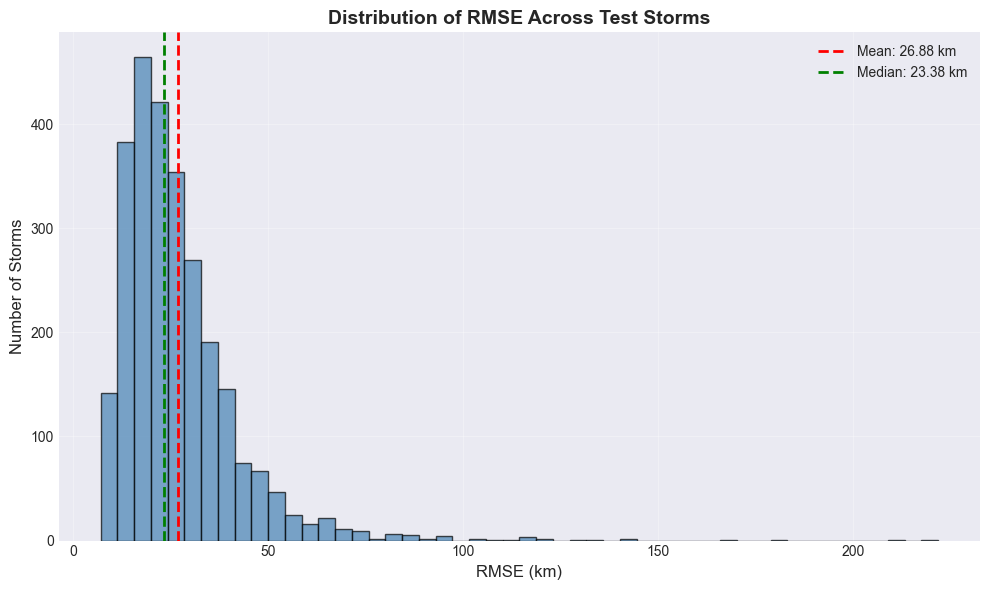

Saved: figures/fig9b_mean_error_distribution.png


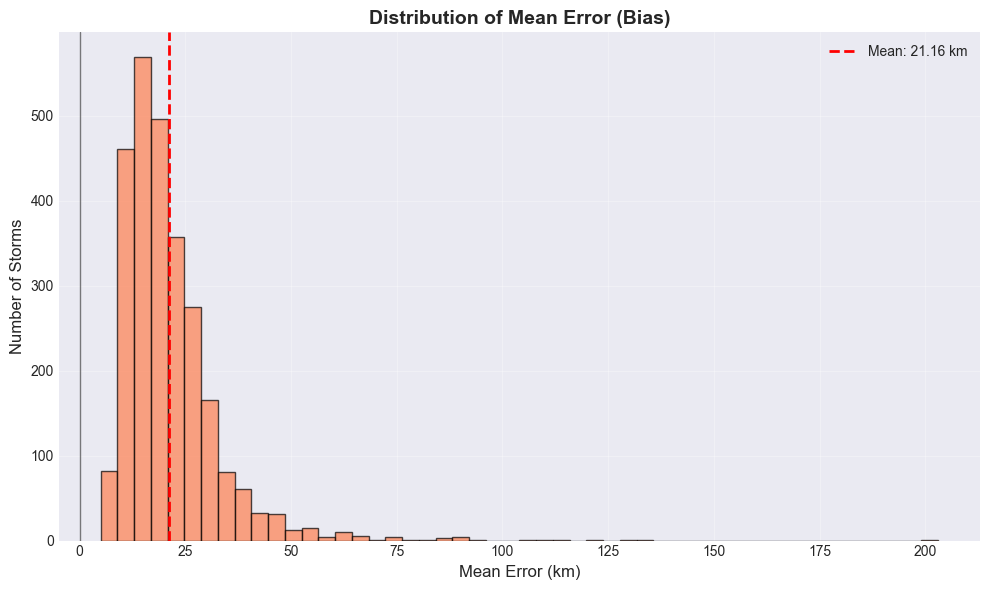

Saved: figures/fig9c_rmse_vs_storm_length.png


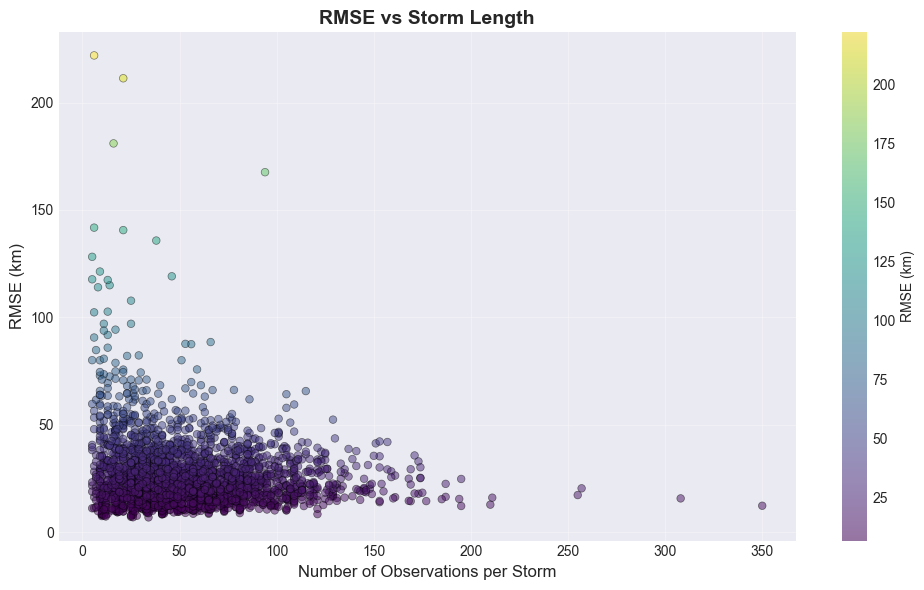

Saved: figures/fig9d_cumulative_rmse_distribution.png


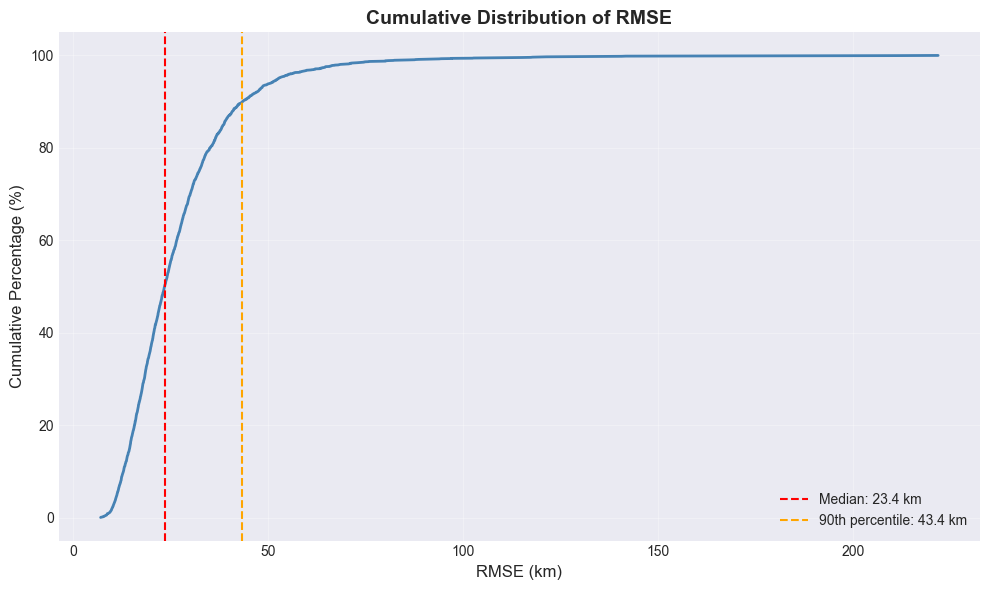

Saved: figures/fig9e_error_by_storm_length.png


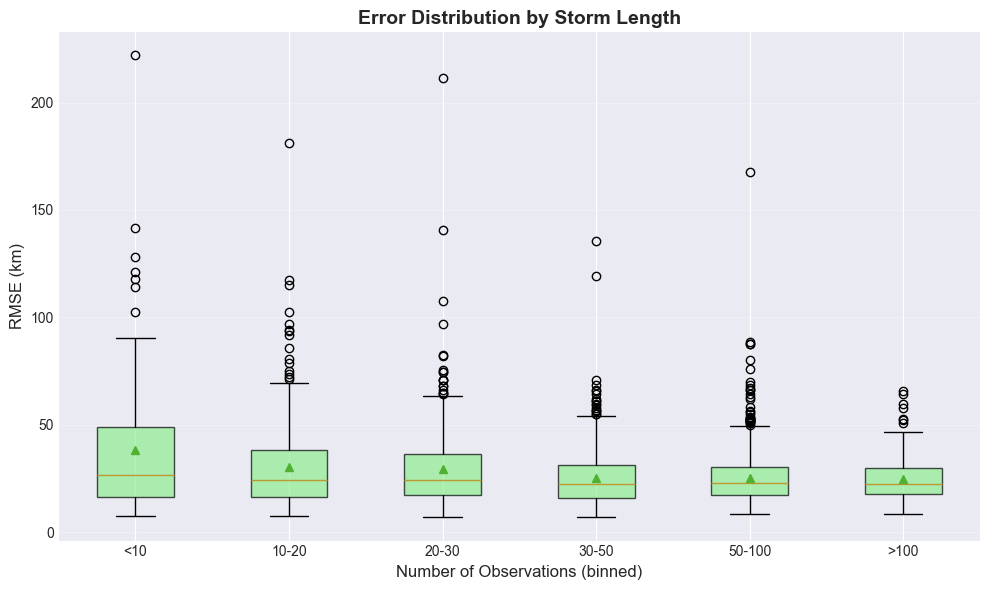

In [ ]:
def plot_error_distribution_analysis(test_results=None, save_dir=None):
    """
    Plot comprehensive error distribution analysis from test set evaluation
    Saves each graph separately
    
    Args:
        test_results: DataFrame with columns ['sid', 'mean_error', 'rmse', 'median_error', 'n_obs']
        save_dir: Directory to save figures
    """
    
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Plot 1: Histogram of RMSE across storms (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.hist(test_results['rmse'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(test_results['rmse'].mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {test_results["rmse"].mean():.2f} km')
    ax1.axvline(test_results['rmse'].median(), color='green', linestyle='--', linewidth=2, 
               label=f'Median: {test_results["rmse"].median():.2f} km')
    ax1.set_xlabel('RMSE (km)', fontsize=12)
    ax1.set_ylabel('Number of Storms', fontsize=12)
    ax1.set_title('Distribution of RMSE Across Test Storms', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9a_rmse_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9a_rmse_distribution.png")
    plt.show()
    
    # Plot 2: Histogram of mean error (separate figure)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    ax2.hist(test_results['mean_error'], bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(test_results['mean_error'].mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Mean: {test_results["mean_error"].mean():.2f} km')
    ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax2.set_xlabel('Mean Error (km)', fontsize=12)
    ax2.set_ylabel('Number of Storms', fontsize=12)
    ax2.set_title('Distribution of Mean Error (Bias)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9b_mean_error_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9b_mean_error_distribution.png")
    plt.show()
    
    # Plot 3: RMSE vs Number of Observations (separate figure)
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    scatter = ax3.scatter(test_results['n_obs'], test_results['rmse'], 
                         alpha=0.5, s=30, c=test_results['rmse'], 
                         cmap='viridis', edgecolors='black', linewidths=0.5)
    ax3.set_xlabel('Number of Observations per Storm', fontsize=12)
    ax3.set_ylabel('RMSE (km)', fontsize=12)
    ax3.set_title('RMSE vs Storm Length', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='RMSE (km)')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9c_rmse_vs_storm_length.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9c_rmse_vs_storm_length.png")
    plt.show()
    
    # Plot 4: Cumulative distribution of errors (separate figure)
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    sorted_rmse = np.sort(test_results['rmse'])
    p = np.arange(1, len(sorted_rmse) + 1) / len(sorted_rmse) * 100
    ax4.plot(sorted_rmse, p, linewidth=2, color='steelblue')
    ax4.axvline(test_results['rmse'].quantile(0.5), color='red', linestyle='--', 
               label=f'Median: {test_results["rmse"].quantile(0.5):.1f} km')
    ax4.axvline(test_results['rmse'].quantile(0.9), color='orange', linestyle='--', 
               label=f'90th percentile: {test_results["rmse"].quantile(0.9):.1f} km')
    ax4.set_xlabel('RMSE (km)', fontsize=12)
    ax4.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax4.set_title('Cumulative Distribution of RMSE', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9d_cumulative_rmse_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9d_cumulative_rmse_distribution.png")
    plt.show()
    
    # Plot 5: Box plot of errors by observation count bins (separate figure)
    fig5, ax5 = plt.subplots(figsize=(10, 6))
    test_results_copy = test_results.copy()
    test_results_copy['obs_bin'] = pd.cut(test_results_copy['n_obs'], 
                                     bins=[0, 10, 20, 30, 50, 100, 1000],
                                     labels=['<10', '10-20', '20-30', '30-50', '50-100', '>100'])
    error_by_bin = [test_results_copy[test_results_copy['obs_bin'] == bin_label]['rmse'].values 
                    for bin_label in test_results_copy['obs_bin'].cat.categories]
    bp = ax5.boxplot(error_by_bin, labels=test_results_copy['obs_bin'].cat.categories, 
                    patch_artist=True, showmeans=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightgreen')
        patch.set_alpha(0.7)
    ax5.set_xlabel('Number of Observations (binned)', fontsize=12)
    ax5.set_ylabel('RMSE (km)', fontsize=12)
    ax5.set_title('Error Distribution by Storm Length', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig9e_error_by_storm_length.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig9e_error_by_storm_length.png")
    plt.show()

# Plot error distribution analysis
if test_results is not None and len(test_results) > 0:
    plot_error_distribution_analysis(test_results, save_dir=SAVE_DIR)
else:
    print("test_results not available. Run test set evaluation first!")


### Figure 10 — Innovation Analysis (Prediction Uncertainty)


Saved: figures/fig10a_innovation_distribution.png


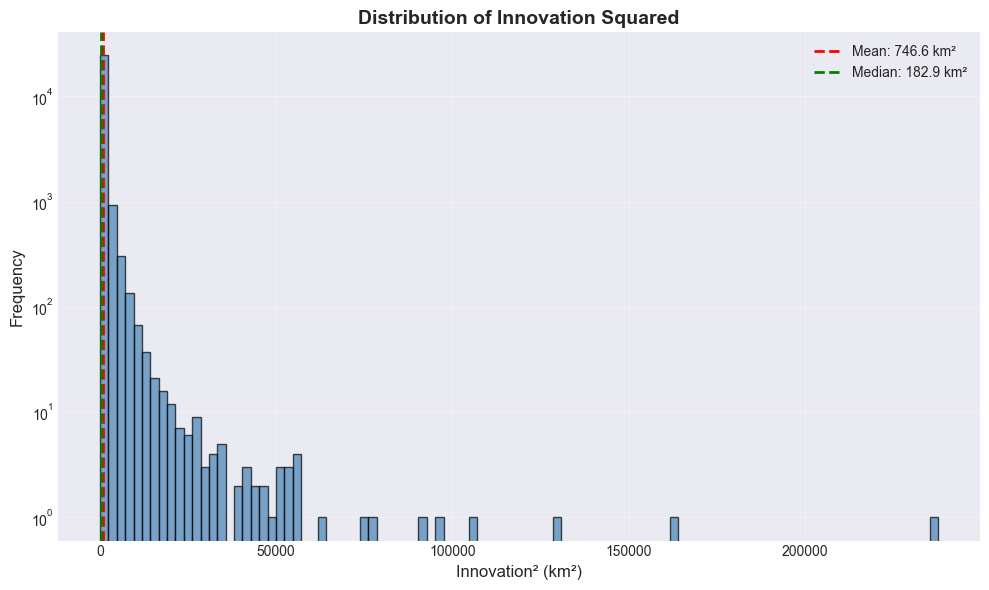

Saved: figures/fig10b_innovation_vs_curvature.png


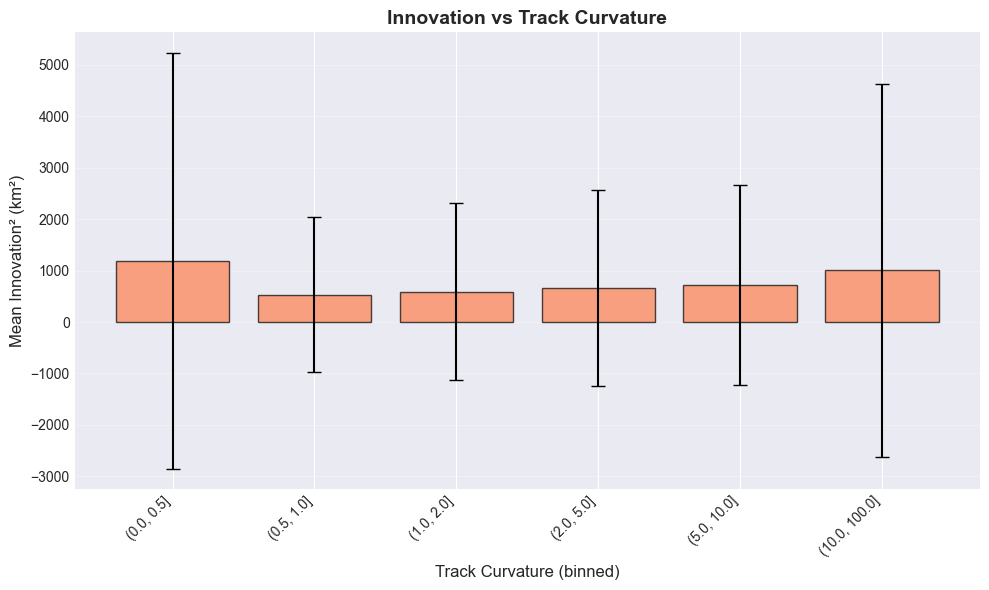

Saved: figures/fig10c_innovation_vs_land.png


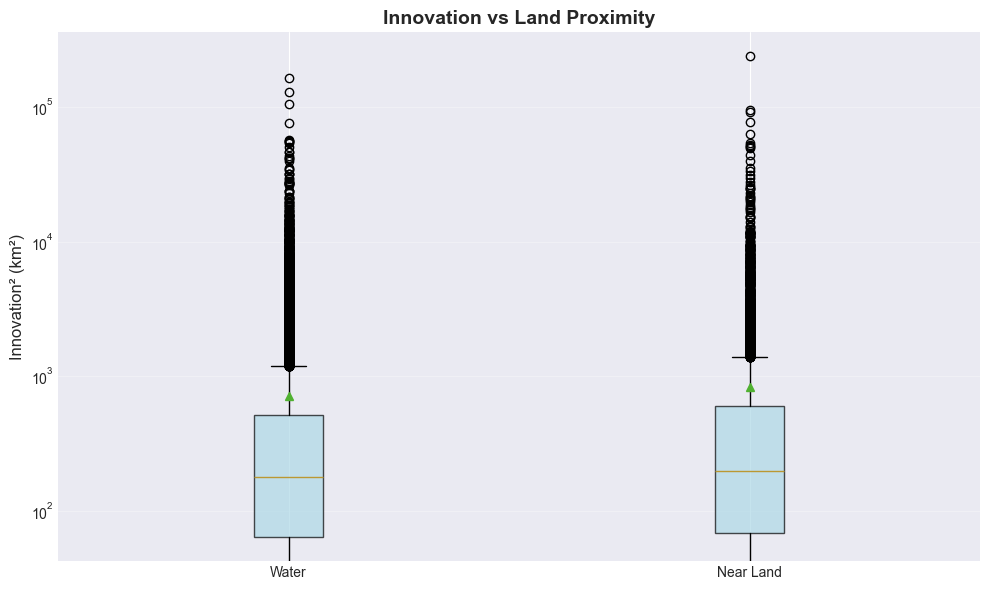

Saved: figures/fig10d_innovation_vs_motion_regime.png


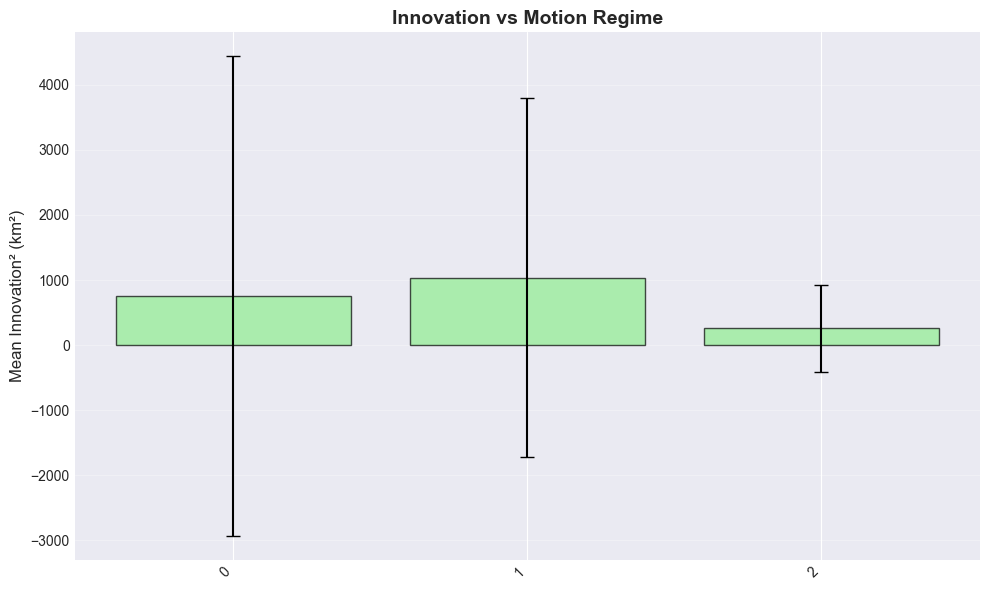

Saved: figures/fig10e_innovation_vs_latitude_regime.png


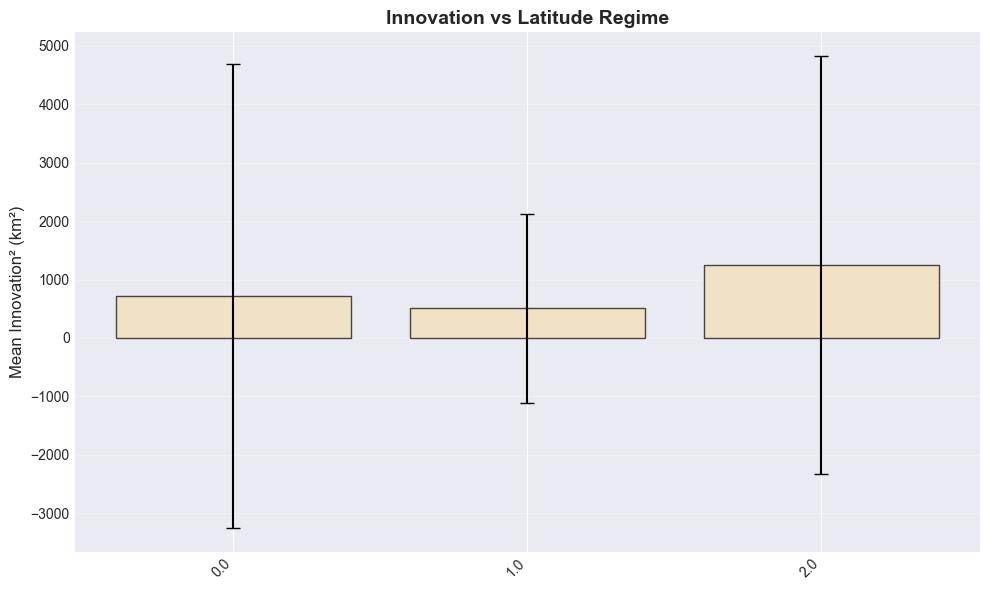

Saved: figures/fig10f_innovation_vs_curvature_scatter.png


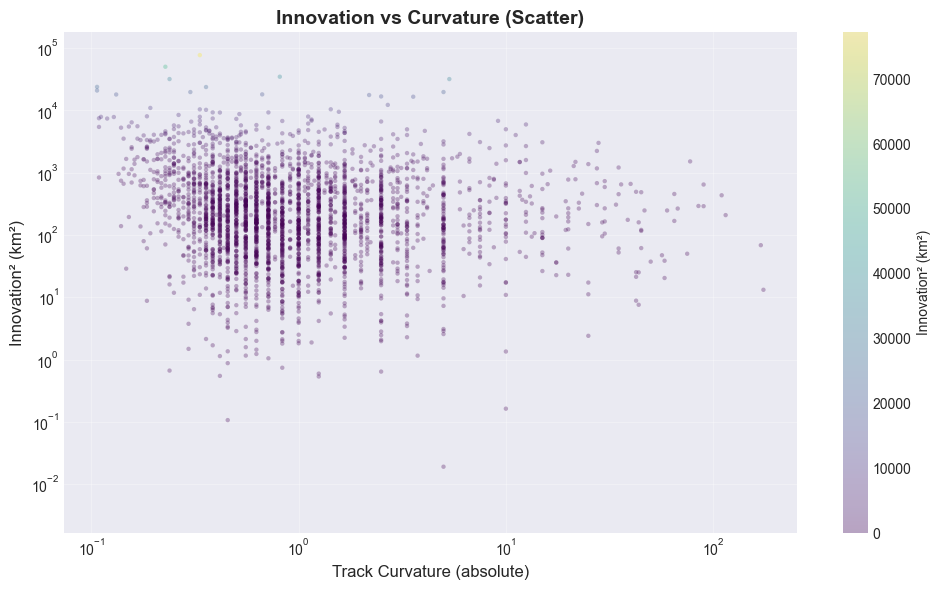

Saved: figures/fig10g_mahalanobis_distance.png


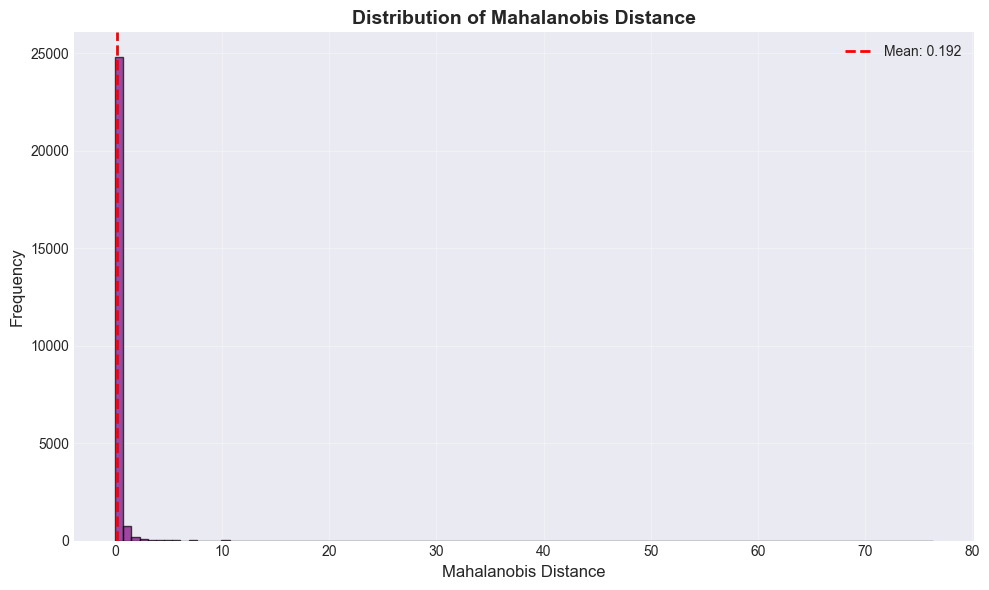

Saved: figures/fig10h_innovation_components.png


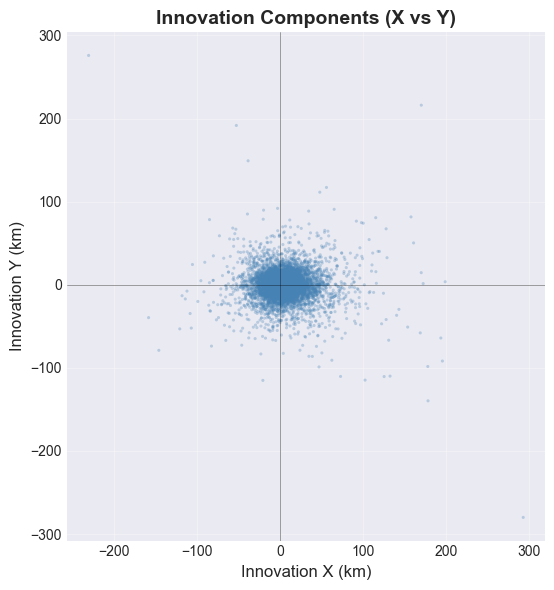

In [ ]:
def plot_innovation_analysis(innovation_df=None, save_dir=None):
    """
    Plot innovation analysis showing how prediction uncertainty relates to storm features
    Saves each graph separately
    
    Args:
        innovation_df: DataFrame with innovation data and feature columns
        save_dir: Directory to save figures
    """
    
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Plot 1: Innovation squared distribution (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    innovation_sq = innovation_df['innovation_squared'].dropna()
    ax1.hist(innovation_sq, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Innovation² (km²)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title('Distribution of Innovation Squared', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    ax1.axvline(innovation_sq.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {innovation_sq.mean():.1f} km²')
    ax1.axvline(innovation_sq.median(), color='green', linestyle='--', linewidth=2,
               label=f'Median: {innovation_sq.median():.1f} km²')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig10a_innovation_distribution.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig10a_innovation_distribution.png")
    plt.show()
    
    # Plot 2: Innovation vs Track Curvature (separate figure)
    if 'track_curvature' in innovation_df.columns:
        fig2, ax2 = plt.subplots(figsize=(10, 6))
        curv_data = innovation_df[innovation_df['track_curvature'].notna()].copy()
        curv_data['curvature_abs'] = curv_data['track_curvature'].abs()
        
        # Create bins for curvature
        curv_bins = [0, 0.5, 1, 2, 5, 10, 100]
        curv_data['curvature_bin'] = pd.cut(curv_data['curvature_abs'], bins=curv_bins)
        
        innovation_by_curv = curv_data.groupby('curvature_bin')['innovation_squared'].agg(['mean', 'median', 'std'])
        
        x_pos = np.arange(len(innovation_by_curv))
        ax2.bar(x_pos, innovation_by_curv['mean'], alpha=0.7, color='coral', 
               edgecolor='black', yerr=innovation_by_curv['std'], capsize=5)
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels([str(c) for c in innovation_by_curv.index], rotation=45, ha='right')
        ax2.set_xlabel('Track Curvature (binned)', fontsize=12)
        ax2.set_ylabel('Mean Innovation² (km²)', fontsize=12)
        ax2.set_title('Innovation vs Track Curvature', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10b_innovation_vs_curvature.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10b_innovation_vs_curvature.png")
        plt.show()
    
    # Plot 3: Innovation vs Land Approach (separate figure)
    if 'is_approaching_land' in innovation_df.columns:
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        land_data = innovation_df[innovation_df['is_approaching_land'].notna()].copy()
        
        land_0 = land_data[land_data['is_approaching_land'] == 0]['innovation_squared']
        land_1 = land_data[land_data['is_approaching_land'] == 1]['innovation_squared']
        
        bp = ax3.boxplot([land_0, land_1], labels=['Water', 'Near Land'], 
                        patch_artist=True, showmeans=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
        ax3.set_ylabel('Innovation² (km²)', fontsize=12)
        ax3.set_title('Innovation vs Land Proximity', fontsize=14, fontweight='bold')
        ax3.set_yscale('log')
        ax3.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10c_innovation_vs_land.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10c_innovation_vs_land.png")
        plt.show()
    
    # Plot 4: Innovation vs Motion Regime (separate figure)
    if 'motion_regime' in innovation_df.columns:
        fig4, ax4 = plt.subplots(figsize=(10, 6))
        regime_data = innovation_df[innovation_df['motion_regime'].notna()].copy()
        
        innovation_by_regime = regime_data.groupby('motion_regime')['innovation_squared'].agg(['mean', 'std'])
        
        x_pos = np.arange(len(innovation_by_regime))
        ax4.bar(x_pos, innovation_by_regime['mean'], alpha=0.7, color='lightgreen',
               edgecolor='black', yerr=innovation_by_regime['std'], capsize=5)
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(innovation_by_regime.index, rotation=45, ha='right')
        ax4.set_ylabel('Mean Innovation² (km²)', fontsize=12)
        ax4.set_title('Innovation vs Motion Regime', fontsize=14, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10d_innovation_vs_motion_regime.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10d_innovation_vs_motion_regime.png")
        plt.show()
    
    # Plot 5: Innovation vs Latitude Regime (separate figure)
    if 'latitude_regime' in innovation_df.columns:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        lat_data = innovation_df[innovation_df['latitude_regime'].notna()].copy()
        
        innovation_by_lat = lat_data.groupby('latitude_regime')['innovation_squared'].agg(['mean', 'std'])
        
        x_pos = np.arange(len(innovation_by_lat))
        ax5.bar(x_pos, innovation_by_lat['mean'], alpha=0.7, color='wheat',
               edgecolor='black', yerr=innovation_by_lat['std'], capsize=5)
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(innovation_by_lat.index, rotation=45, ha='right')
        ax5.set_ylabel('Mean Innovation² (km²)', fontsize=12)
        ax5.set_title('Innovation vs Latitude Regime', fontsize=14, fontweight='bold')
        ax5.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10e_innovation_vs_latitude_regime.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10e_innovation_vs_latitude_regime.png")
        plt.show()
    
    # Plot 6: Scatter plot of innovation vs curvature (separate figure)
    if 'track_curvature' in innovation_df.columns:
        fig6, ax6 = plt.subplots(figsize=(10, 6))
        curv_scatter = innovation_df[innovation_df['track_curvature'].notna()].copy()
        curv_scatter['curvature_abs'] = curv_scatter['track_curvature'].abs()
        
        # Sample for visualization if too many points
        if len(curv_scatter) > 5000:
            curv_scatter = curv_scatter.sample(n=5000, random_state=42)
        
        scatter = ax6.scatter(curv_scatter['curvature_abs'], curv_scatter['innovation_squared'],
                             alpha=0.3, s=10, c=curv_scatter['innovation_squared'],
                             cmap='viridis', edgecolors='none')
        ax6.set_xlabel('Track Curvature (absolute)', fontsize=12)
        ax6.set_ylabel('Innovation² (km²)', fontsize=12)
        ax6.set_title('Innovation vs Curvature (Scatter)', fontsize=14, fontweight='bold')
        ax6.set_yscale('log')
        ax6.set_xscale('log')
        ax6.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax6, label='Innovation² (km²)')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10f_innovation_vs_curvature_scatter.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10f_innovation_vs_curvature_scatter.png")
        plt.show()
    
    # Plot 7: Mahalanobis distance distribution (separate figure)
    if 'mahalanobis_distance' in innovation_df.columns:
        fig7, ax7 = plt.subplots(figsize=(10, 6))
        mahal_dist = innovation_df['mahalanobis_distance'].dropna()
        ax7.hist(mahal_dist, bins=100, edgecolor='black', alpha=0.7, color='purple')
        ax7.set_xlabel('Mahalanobis Distance', fontsize=12)
        ax7.set_ylabel('Frequency', fontsize=12)
        ax7.set_title('Distribution of Mahalanobis Distance', fontsize=14, fontweight='bold')
        ax7.axvline(mahal_dist.mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mahal_dist.mean():.3f}')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10g_mahalanobis_distance.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10g_mahalanobis_distance.png")
        plt.show()
    
    # Plot 8: Innovation components (x vs y) (separate figure)
    if 'innovation_x' in innovation_df.columns and 'innovation_y' in innovation_df.columns:
        fig8, ax8 = plt.subplots(figsize=(10, 6))
        innov_sample = innovation_df[['innovation_x', 'innovation_y']].dropna()
        if len(innov_sample) > 10000:
            innov_sample = innov_sample.sample(n=10000, random_state=42)
        
        ax8.scatter(innov_sample['innovation_x'], innov_sample['innovation_y'],
                   alpha=0.3, s=5, c='steelblue', edgecolors='none')
        ax8.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax8.axvline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
        ax8.set_xlabel('Innovation X (km)', fontsize=12)
        ax8.set_ylabel('Innovation Y (km)', fontsize=12)
        ax8.set_title('Innovation Components (X vs Y)', fontsize=14, fontweight='bold')
        ax8.grid(True, alpha=0.3)
        ax8.set_aspect('equal')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig10h_innovation_components.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig10h_innovation_components.png")
        plt.show()

# Plot innovation analysis
if innovation_df is not None and len(innovation_df) > 0:
    plot_innovation_analysis(innovation_df, save_dir=SAVE_DIR)
else:
    print("innovation_df not available. Run feature validation first!")


### Figure 11 — Model Comparison (Baseline vs Adaptive-Q)


Saved: figures/fig11a_rmse_comparison.png


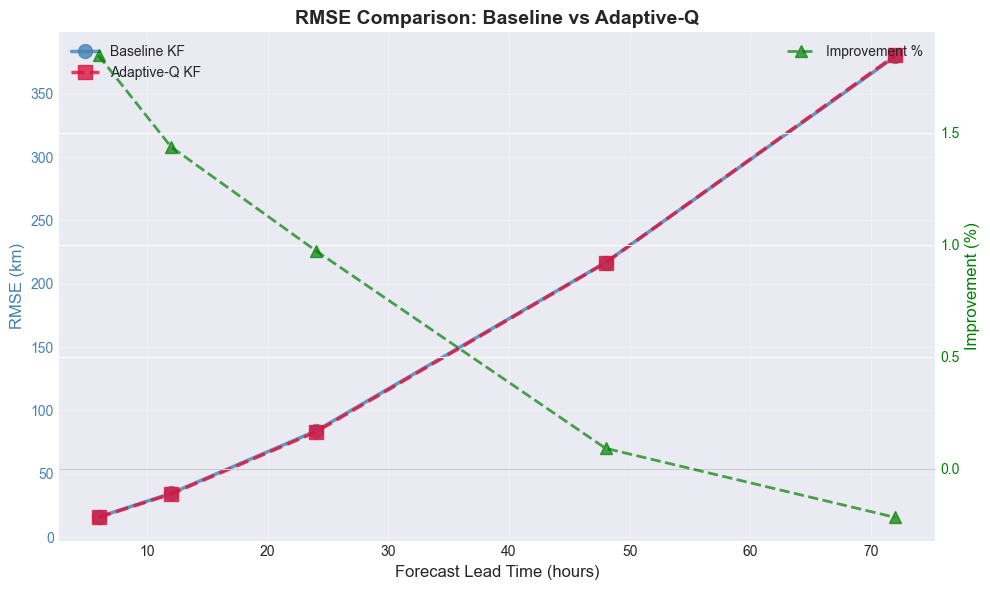

Saved: figures/fig11b_error_distribution_comparison.png


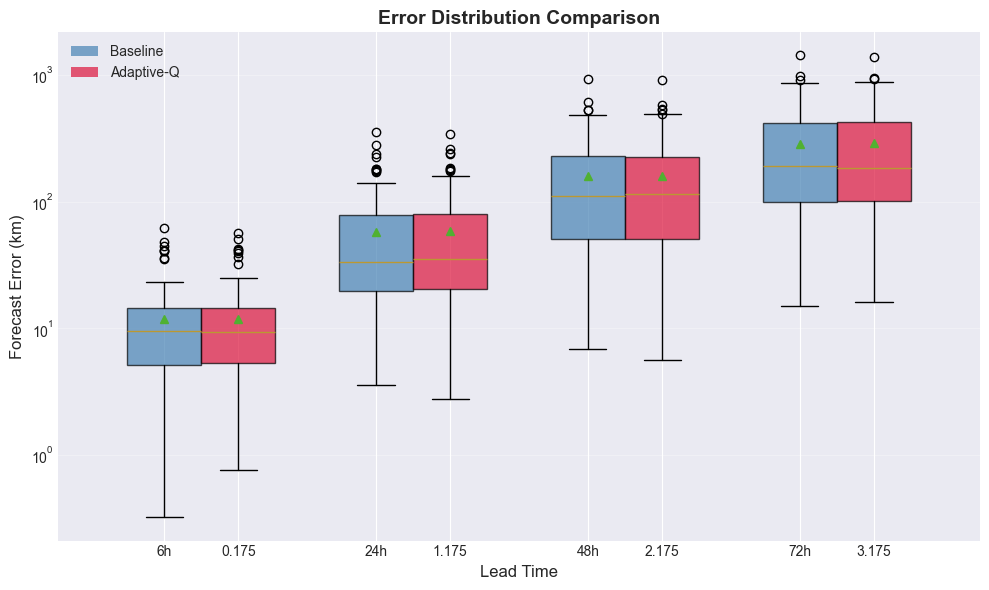

Saved: figures/fig11c_improvement_by_leadtime.png


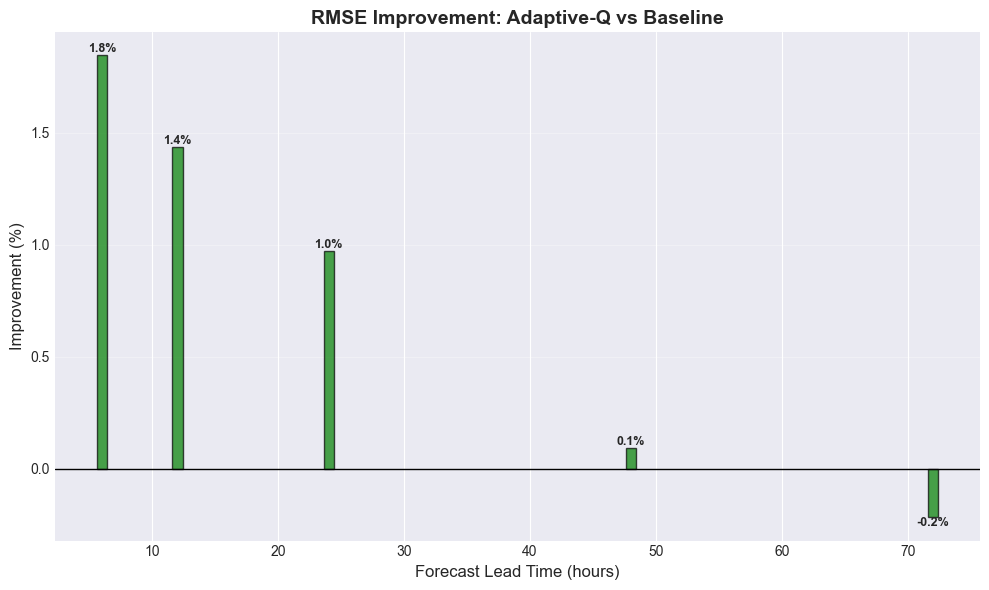

Saved: figures/fig11d_cumulative_error_comparison.png


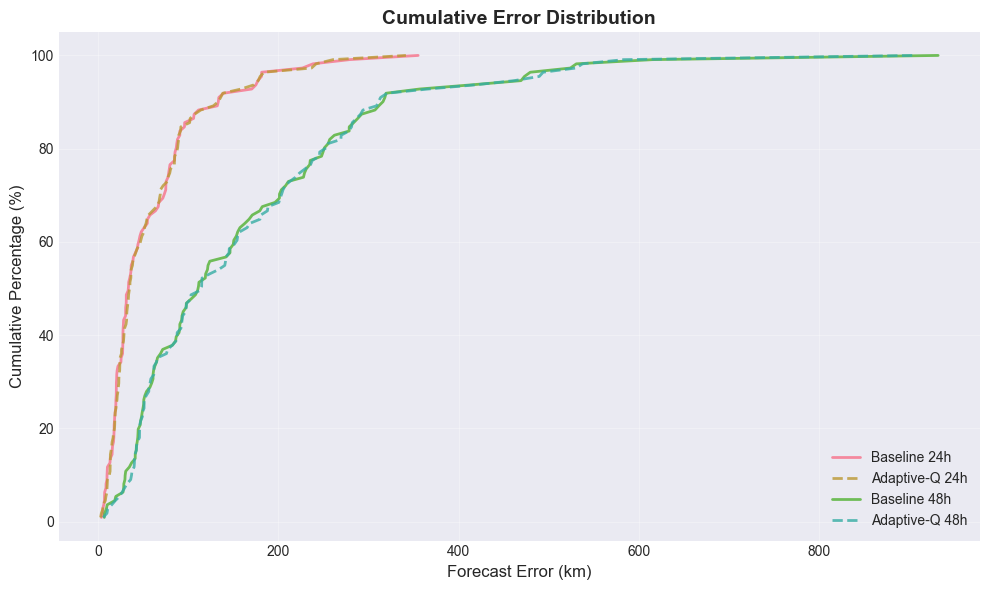

Saved: figures/fig11e_error_scatter_comparison.png


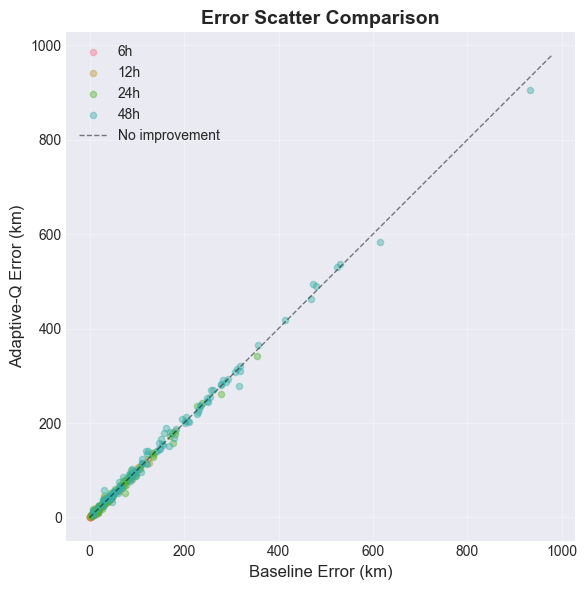

In [ ]:
def plot_model_comparison(sliding_results_baseline=None, sliding_results_improved=None,
                          save_dir=None):
    """
    Comprehensive comparison between baseline and adaptive-Q models
    Saves each graph separately
    
    Args:
        sliding_results_baseline: DataFrame with baseline forecast results
        sliding_results_improved: DataFrame with adaptive-Q forecast results
        save_dir: Directory to save figures
    """
    

    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Calculate statistics for baseline
    baseline_stats = sliding_results_baseline.groupby('lead_time_hours')['error_km'].agg([
        lambda x: np.sqrt(np.mean(x**2)),  # RMSE
        'mean',  # Mean error
        'median',  # Median error
        lambda x: np.percentile(x, 25),  # Q25
        lambda x: np.percentile(x, 75),  # Q75
    ]).sort_index()
    baseline_stats.columns = ['rmse', 'mean', 'median', 'q25', 'q75']
    
    lead_times = baseline_stats.index.values
    
    # Calculate improved stats if available
    improved_stats = None
    if sliding_results_improved is not None and len(sliding_results_improved) > 0:
        improved_stats = sliding_results_improved.groupby('lead_time_hours')['error_km'].agg([
            lambda x: np.sqrt(np.mean(x**2)),
            'mean',
            'median',
            lambda x: np.percentile(x, 25),
            lambda x: np.percentile(x, 75),
        ]).sort_index()
        improved_stats.columns = ['rmse', 'mean', 'median', 'q25', 'q75']
    
    # Plot 1: RMSE comparison (separate figure)
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(lead_times, baseline_stats['rmse'], 'o-', linewidth=2.5, markersize=10,
            label='Baseline KF', color='steelblue', alpha=0.8)
    
    if improved_stats is not None:
        ax1.plot(lead_times, improved_stats['rmse'], 's-', linewidth=2.5, markersize=10,
                label='Adaptive-Q KF', color='crimson', linestyle='--', alpha=0.8)
        
        # Calculate improvement percentage
        improvement_pct = ((baseline_stats['rmse'] - improved_stats['rmse']) / baseline_stats['rmse'] * 100)
        ax1_twin = ax1.twinx()
        ax1_twin.plot(lead_times, improvement_pct, 'g--', linewidth=2, marker='^', markersize=8,
                     label='Improvement %', alpha=0.7)
        ax1_twin.set_ylabel('Improvement (%)', fontsize=12, color='green')
        ax1_twin.tick_params(axis='y', labelcolor='green')
        ax1_twin.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax1_twin.legend(loc='upper right')
    
    ax1.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
    ax1.set_ylabel('RMSE (km)', fontsize=12, color='steelblue')
    ax1.set_title('RMSE Comparison: Baseline vs Adaptive-Q', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='steelblue')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig11a_rmse_comparison.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig11a_rmse_comparison.png")
    plt.show()
    
    # Plot 2: Error distribution comparison at key lead times (separate figure)
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    key_lead_times = [6, 24, 48, 72]
    key_lead_times = [lt for lt in key_lead_times if lt in lead_times]
    
    baseline_errors = []
    improved_errors = []
    labels = []
    
    for lt in key_lead_times:
        baseline_errors.append(sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km'].values)
        labels.append(f'{int(lt)}h')
        if sliding_results_improved is not None:
            improved_errors.append(sliding_results_improved[sliding_results_improved['lead_time_hours'] == lt]['error_km'].values)
    
    # Create grouped box plot
    positions = np.arange(len(key_lead_times))
    width = 0.35
    
    bp1 = ax2.boxplot(baseline_errors, positions=positions - width/2, widths=width,
                     patch_artist=True, labels=labels, showmeans=True)
    for patch in bp1['boxes']:
        patch.set_facecolor('steelblue')
        patch.set_alpha(0.7)
    
    if sliding_results_improved is not None and len(improved_errors) > 0:
        bp2 = ax2.boxplot(improved_errors, positions=positions + width/2, widths=width,
                         patch_artist=True, showmeans=True)
        for patch in bp2['boxes']:
            patch.set_facecolor('crimson')
            patch.set_alpha(0.7)
    
    ax2.set_xlabel('Lead Time', fontsize=12)
    ax2.set_ylabel('Forecast Error (km)', fontsize=12)
    ax2.set_title('Error Distribution Comparison', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='steelblue', alpha=0.7, label='Baseline'),
                       Patch(facecolor='crimson', alpha=0.7, label='Adaptive-Q')]
    ax2.legend(handles=legend_elements, loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig11b_error_distribution_comparison.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig11b_error_distribution_comparison.png")
    plt.show()
    
    # Plot 3: Improvement by lead time (bar chart) (separate figure)
    if improved_stats is not None:
        fig3, ax3 = plt.subplots(figsize=(10, 6))
        improvement_km = baseline_stats['rmse'] - improved_stats['rmse']
        improvement_pct = (improvement_km / baseline_stats['rmse'] * 100)
        
        bars = ax3.bar(lead_times, improvement_pct, alpha=0.7, color='green', edgecolor='black')
        ax3.axhline(0, color='black', linestyle='-', linewidth=1)
        ax3.set_xlabel('Forecast Lead Time (hours)', fontsize=12)
        ax3.set_ylabel('Improvement (%)', fontsize=12)
        ax3.set_title('RMSE Improvement: Adaptive-Q vs Baseline', fontsize=14, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, pct in zip(bars, improvement_pct):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{pct:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                    fontsize=9, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig11c_improvement_by_leadtime.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig11c_improvement_by_leadtime.png")
        plt.show()
    
    # Plot 4: Cumulative error distribution comparison (separate figure)
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    for lt in [24, 48] if 24 in lead_times and 48 in lead_times else [lead_times[0] if len(lead_times) > 0 else 6]:
        if lt not in lead_times:
            continue
        baseline_lt = sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km']
        sorted_baseline = np.sort(baseline_lt)
        p_baseline = np.arange(1, len(sorted_baseline) + 1) / len(sorted_baseline) * 100
        
        ax4.plot(sorted_baseline, p_baseline, linewidth=2, label=f'Baseline {int(lt)}h', alpha=0.8)
        
        if sliding_results_improved is not None:
            improved_lt = sliding_results_improved[sliding_results_improved['lead_time_hours'] == lt]['error_km']
            sorted_improved = np.sort(improved_lt)
            p_improved = np.arange(1, len(sorted_improved) + 1) / len(sorted_improved) * 100
            ax4.plot(sorted_improved, p_improved, linewidth=2, linestyle='--',
                    label=f'Adaptive-Q {int(lt)}h', alpha=0.8)
    
    ax4.set_xlabel('Forecast Error (km)', fontsize=12)
    ax4.set_ylabel('Cumulative Percentage (%)', fontsize=12)
    ax4.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{save_dir}fig11d_cumulative_error_comparison.png', dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_dir}fig11d_cumulative_error_comparison.png")
    plt.show()
    
    # Plot 5: Error scatter comparison (separate figure)
    if sliding_results_improved is not None and len(sliding_results_improved) > 0:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        # Compare errors at same lead times
        common_lead_times = set(sliding_results_baseline['lead_time_hours']) & set(sliding_results_improved['lead_time_hours'])
        
        for lt in sorted(common_lead_times)[:4]:  # Show up to 4 lead times
            baseline_errors = sliding_results_baseline[sliding_results_baseline['lead_time_hours'] == lt]['error_km']
            improved_errors = sliding_results_improved[sliding_results_improved['lead_time_hours'] == lt]['error_km']
            
            # Sample if too many points
            if len(baseline_errors) > 200:
                idx = np.random.choice(len(baseline_errors), 200, replace=False)
                baseline_errors = baseline_errors.iloc[idx]
                improved_errors = improved_errors.iloc[idx]
            
            ax5.scatter(baseline_errors, improved_errors, alpha=0.4, s=20, label=f'{int(lt)}h')
        
        # Add diagonal line (y=x)
        max_err = max(ax5.get_xlim()[1], ax5.get_ylim()[1])
        ax5.plot([0, max_err], [0, max_err], 'k--', linewidth=1, alpha=0.5, label='No improvement')
        
        ax5.set_xlabel('Baseline Error (km)', fontsize=12)
        ax5.set_ylabel('Adaptive-Q Error (km)', fontsize=12)
        ax5.set_title('Error Scatter Comparison', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        ax5.set_aspect('equal')
        plt.tight_layout()
        plt.savefig(f'{save_dir}fig11e_error_scatter_comparison.png', dpi=DPI, bbox_inches='tight')
        print(f"Saved: {save_dir}fig11e_error_scatter_comparison.png")
        plt.show()

# Plot model comparison
if sliding_results is not None and sliding_results_final is not None:
    plot_model_comparison(
        sliding_results_baseline=sliding_results,
        sliding_results_improved=sliding_results_final,
        save_dir=SAVE_DIR
    )
else:
    print("Results not available for comparison. Run evaluations first!")


### Figure 12 — Average Prediction Error Over Time with Confidence Intervals


Saved: figures/fig12_average_predictions_over_time_6h.png


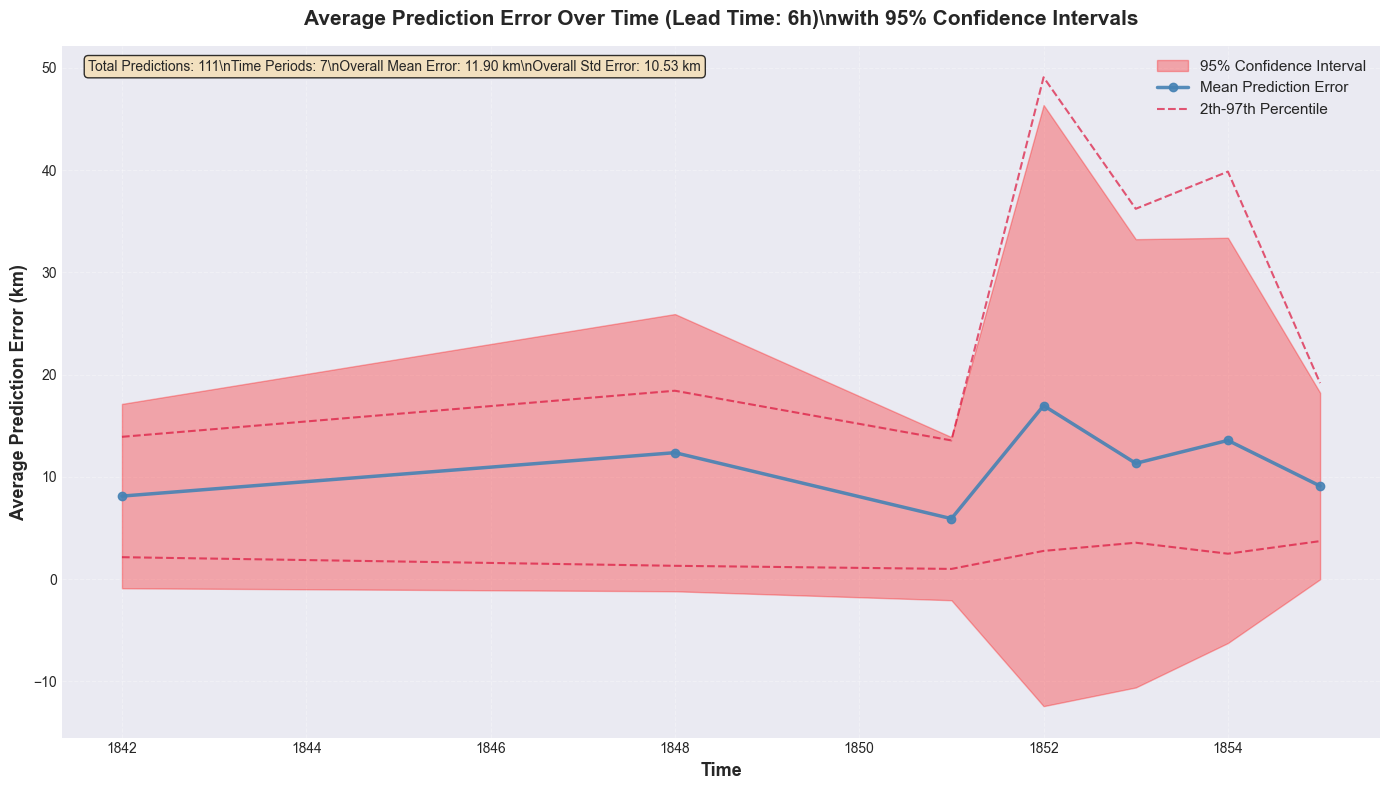

Saved: figures/fig12_average_predictions_over_time_24h.png


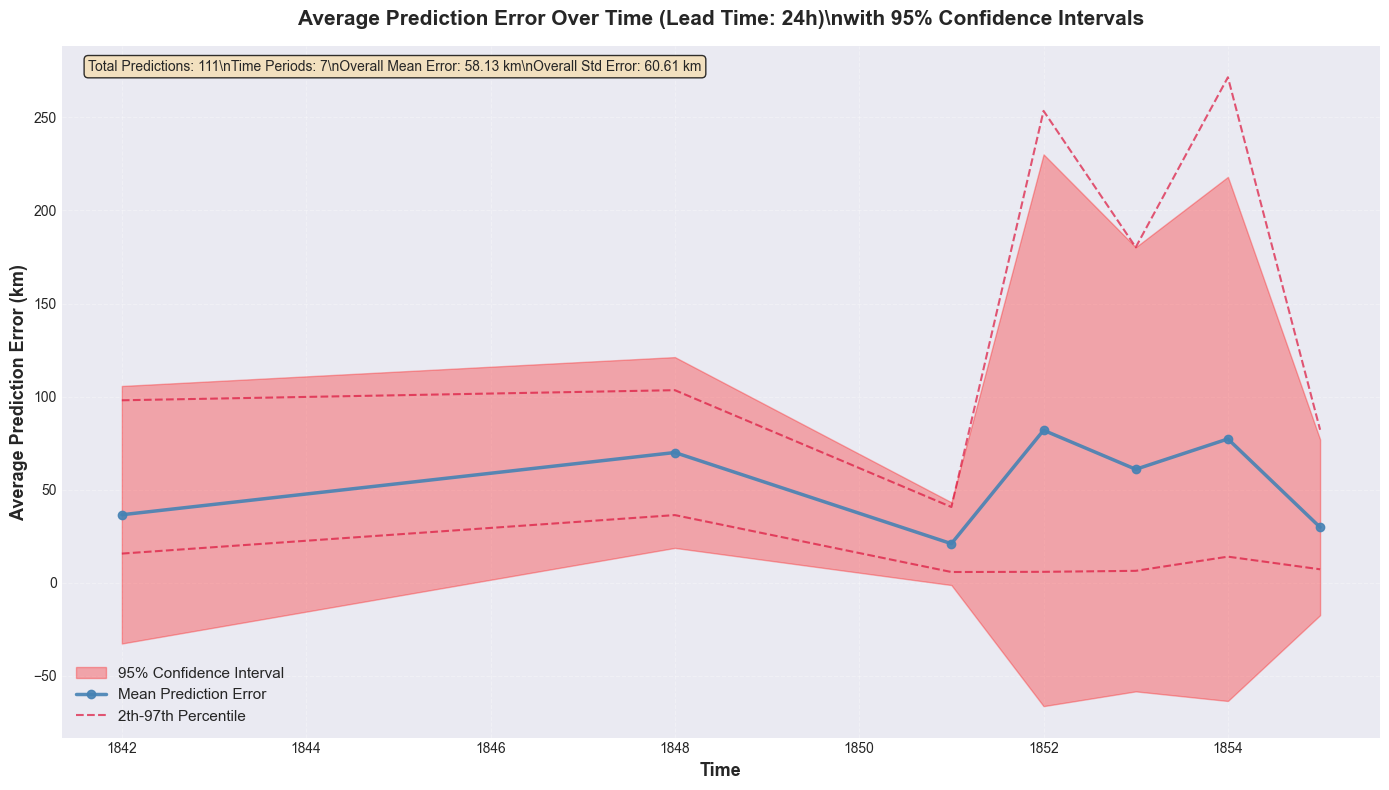

Saved: figures/fig12_average_predictions_over_time_48h.png


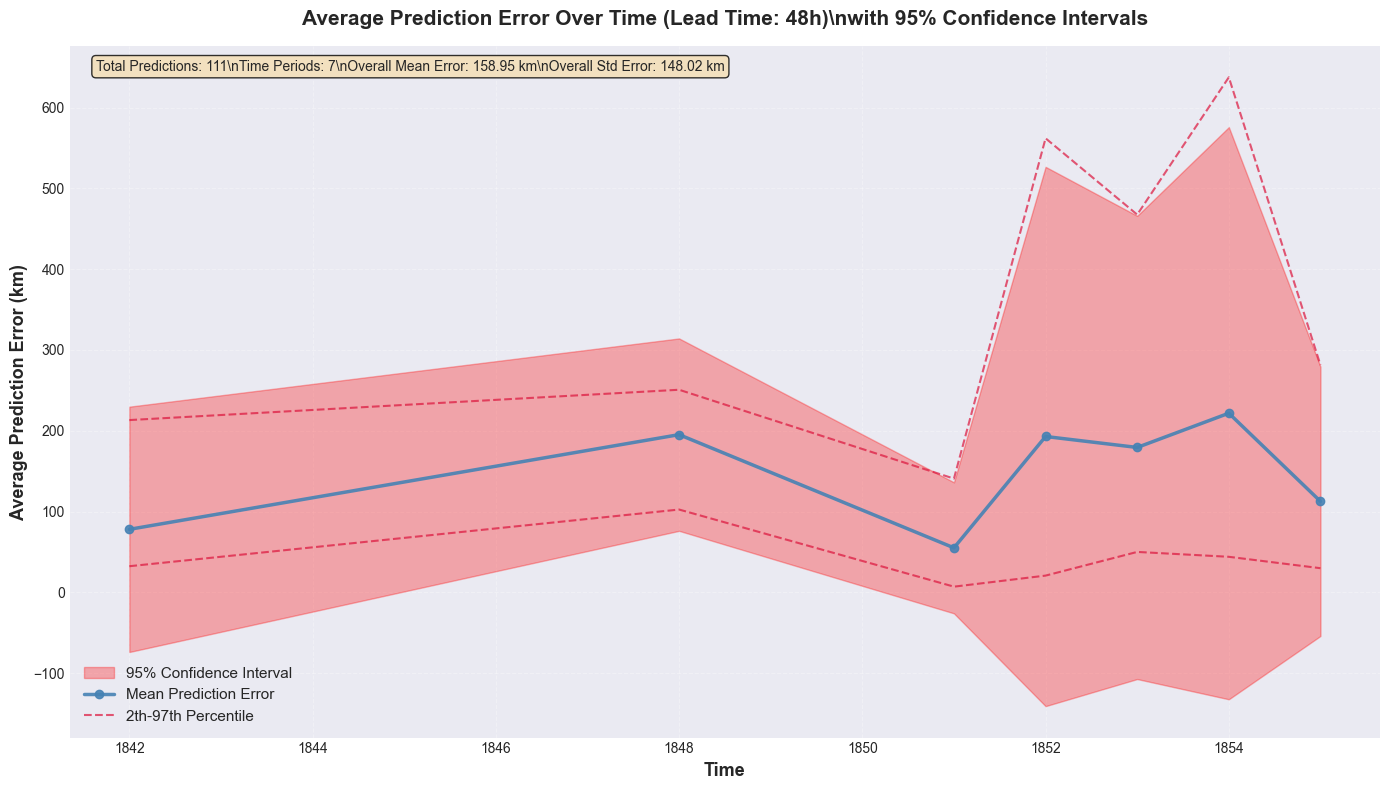

In [ ]:
def plot_average_predictions_over_time(sliding_results=None, df_main=None, 
                                       time_period='year', lead_time_hours=24,
                                       confidence_level=0.95, save_dir=None):
    """
    Plot average prediction error over time with confidence intervals
    
    Args:
        sliding_results: DataFrame with forecast results (storm_id, lead_time_hours, error_km)
        df_main: Main dataset with iso_time and sid columns
        time_period: 'year', 'month', or 'quarter' for grouping
        lead_time_hours: Which lead time to analyze (default: 24 hours)
        confidence_level: Confidence level for intervals (default: 0.95 = 95%)
    """
    
    if save_dir is None:
        save_dir = SAVE_DIR
    
    # Filter to specific lead time
    results_filtered = sliding_results[sliding_results['lead_time_hours'] == lead_time_hours].copy()
    
    if len(results_filtered) == 0:
        print(f"Warning: No results found for lead_time_hours={lead_time_hours}")
        return
    
    # Extract date from storm_id or merge with main dataset
    # Storm ID format appears to be: YYYYMMDD... 
    # Let's try to extract year from storm_id first
    def extract_year_from_storm_id(storm_id):
        """Extract year from storm ID if possible"""
        try:
            # Try first 4 characters as year
            year_str = str(storm_id)[:4]
            year = int(year_str)
            if 1800 <= year <= 2100:
                return year
        except:
            pass
        return None
    
    # Try extracting year from storm_id
    results_filtered['year'] = results_filtered['storm_id'].apply(extract_year_from_storm_id)
    
    # If that doesn't work well, merge with main dataset to get actual dates
    if results_filtered['year'].isna().sum() > len(results_filtered) * 0.5:
        print("Merging with main dataset to get time information...")
        # Get first observation time for each storm
        storm_times = df_main.groupby('sid')['iso_time'].first().reset_index()
        storm_times.columns = ['storm_id', 'iso_time']
        
        # Merge
        results_filtered = results_filtered.merge(storm_times, on='storm_id', how='left')
        
        if 'iso_time' in results_filtered.columns:
            results_filtered['year'] = results_filtered['iso_time'].dt.year
            results_filtered['month'] = results_filtered['iso_time'].dt.month
            results_filtered['quarter'] = results_filtered['iso_time'].dt.quarter
            results_filtered['date'] = results_filtered['iso_time']
    
    # Remove rows without time information
    results_filtered = results_filtered.dropna(subset=['year'])
    
    if len(results_filtered) == 0:
        print("Error: Could not extract time information from results")
        return
    
    # Group by time period
    if time_period == 'year':
        time_col = 'year'
        results_filtered['time_period'] = results_filtered['year']
    elif time_period == 'month':
        if 'date' in results_filtered.columns:
            results_filtered['time_period'] = results_filtered['date'].dt.to_period('M')
        else:
            print("Warning: Month grouping requires date information. Using year instead.")
            time_col = 'year'
            results_filtered['time_period'] = results_filtered['year']
    elif time_period == 'quarter':
        if 'date' in results_filtered.columns:
            results_filtered['time_period'] = results_filtered['date'].dt.to_period('Q')
        else:
            print("Warning: Quarter grouping requires date information. Using year instead.")
            time_col = 'year'
            results_filtered['time_period'] = results_filtered['year']
    else:
        time_col = 'year'
        results_filtered['time_period'] = results_filtered['year']
    
    # Calculate statistics for each time period
    time_stats = results_filtered.groupby('time_period')['error_km'].agg([
        'mean',  # Average error
        'std',   # Standard deviation
        'count', # Number of predictions
        lambda x: np.percentile(x, (1 - confidence_level) / 2 * 100),  # Lower bound
        lambda x: np.percentile(x, (1 + confidence_level) / 2 * 100),  # Upper bound
    ]).reset_index()
    time_stats.columns = ['time_period', 'mean_error', 'std_error', 'count', 'lower_bound', 'upper_bound']
    
    # Calculate confidence intervals (using std or percentiles)
    # Option 1: Use percentiles (already calculated)
    # Option 2: Use mean ± z * std (for normal approximation)
    from scipy import stats
    z_score = stats.norm.ppf((1 + confidence_level) / 2)
    time_stats['ci_lower'] = time_stats['mean_error'] - z_score * time_stats['std_error']
    time_stats['ci_upper'] = time_stats['mean_error'] + z_score * time_stats['std_error']
    
    # Sort by time period
    time_stats = time_stats.sort_values('time_period')
    
    # Convert time_period to numeric/date for plotting
    if time_period == 'year':
        time_stats['time_plot'] = time_stats['time_period'].astype(int)
    elif time_period in ['month', 'quarter']:
        time_stats['time_plot'] = time_stats['time_period'].astype(str)
        # Convert to datetime for better plotting
        try:
            time_stats['time_plot'] = pd.to_datetime(time_stats['time_plot'])
        except:
            pass
    else:
        time_stats['time_plot'] = time_stats['time_period']
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Plot confidence intervals (shaded area)
    ax.fill_between(time_stats['time_plot'], time_stats['ci_lower'], time_stats['ci_upper'],
                    alpha=0.3, color='red', label=f'{int(confidence_level*100)}% Confidence Interval')
    
    # Plot mean error (central line)
    ax.plot(time_stats['time_plot'], time_stats['mean_error'], 
           'o-', linewidth=2.5, markersize=6, color='steelblue', 
           label='Mean Prediction Error', alpha=0.9)
    
    # Also plot percentile bounds as dashed lines
    ax.plot(time_stats['time_plot'], time_stats['lower_bound'], 
           '--', linewidth=1.5, color='crimson', alpha=0.7, 
           label=f'{int((1-confidence_level)/2*100)}th-{int((1+confidence_level)/2*100)}th Percentile')
    ax.plot(time_stats['time_plot'], time_stats['upper_bound'], 
           '--', linewidth=1.5, color='crimson', alpha=0.7)
    
    # Formatting
    ax.set_xlabel('Time', fontsize=13, fontweight='bold')
    ax.set_ylabel(f'Average Prediction Error (km)', fontsize=13, fontweight='bold')
    ax.set_title(f'Average Prediction Error Over Time (Lead Time: {lead_time_hours}h)\\n'
                f'with {int(confidence_level*100)}% Confidence Intervals', 
                fontsize=15, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Format x-axis for dates
    if time_period in ['month', 'quarter']:
        try:
            from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
            ax.xaxis.set_major_locator(YearLocator())
            ax.xaxis.set_minor_locator(MonthLocator((1, 7)))
            ax.xaxis.set_major_formatter(DateFormatter('%Y'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        except:
            pass
    
    # Add statistics text box
    stats_text = f"Total Predictions: {len(results_filtered):,}\\n"
    stats_text += f"Time Periods: {len(time_stats)}\\n"
    stats_text += f"Overall Mean Error: {results_filtered['error_km'].mean():.2f} km\\n"
    stats_text += f"Overall Std Error: {results_filtered['error_km'].std():.2f} km"
    
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    save_path = f'{save_dir}fig12_average_predictions_over_time_{lead_time_hours}h.png'
    plt.savefig(save_path, dpi=DPI, bbox_inches='tight')
    print(f"Saved: {save_path}")
    plt.show()
    
    return time_stats

# Plot average predictions over time
if sliding_results is not None and len(sliding_results) > 0:
    # Load main dataset for time information
    try:
        df_main = pd.read_pickle("data/hurricane_paths_processed.pkl")
        
        # Create plots for different lead times
        for lead_time in [6, 24, 48]:
            if lead_time in sliding_results['lead_time_hours'].values:
                plot_average_predictions_over_time(
                    sliding_results=sliding_results,
                    df_main=df_main,
                    time_period='year',
                    lead_time_hours=lead_time,
                    confidence_level=0.95,
                    save_dir=SAVE_DIR
                )
    except Exception as e:
        print(f"Error creating time series plot: {e}")
        print("Trying with available data only...")
        # Try without main dataset
        plot_average_predictions_over_time(
            sliding_results=sliding_results,
            df_main=None,
            time_period='year',
            lead_time_hours=24,
            confidence_level=0.95,
            save_dir=SAVE_DIR
        )
else:
    print("sliding_results not available. Run evaluation first!")
